In [113]:
# importing libraries
import pandas as pd
import conorm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata
from typing import Union, List
import warnings
import os
warnings.filterwarnings("ignore")
import sys
sys.path.append('../scripts')  

import plotting_utils as mplt
from de_gsea import run_pipeline

sys.path.append('../notebooks')  


# # load the data
metadata_df = pd.read_csv('../data/metadata.csv', index_col=0)
expression_df = pd.read_csv('../data/raw_expression.csv', index_col=0)
scaled_expression = pd.read_csv('../data/scaled_log_expression.csv', index_col=0)


# 2.Exploring Cancer-Specific Variables for data with survival information

To better understand the clinical and molecular landscape of colorectal cancer (CRC) within this dataset, we now focus **exclusively on tumor (cancerous) samples** with survival analysis information.


#### Key Cancer-Related Variables to Explore:

- **Mutation data**: `braf_mutation`, `kras_mutation`, `egfr_mutated`, `tp53_mutation`
- **Tumor characteristics**: `stage`, `grade`, `histological_type`, `histological_subtype`, `tumor_type`
- **Molecular classification**: `cms`, `molecular_type`, `msi_status`, `tmb`, `tmb_group`
- **Treatment & response**: `line_of_treatment`, `therapy_type`, `therapy_response`, `prior_treatment`
- **Target**: `os_time`, `os_status`


#### Goals of This Exploration

- Summarize the availability and distribution of cancer-specific variables.
- Identify patterns, subgroups, or correlations that may inform downstream analysis (survival analysis).
- Decide which variables are suitable for **modeling or biological interpretation** and which may need to be excluded due to poor data quality.


In [114]:
cancer_df = metadata_df[(metadata_df['os_status'].notna())& (metadata_df['os_time'].notna())].copy()
cancer_df = cancer_df[cancer_df['biopsy_timepoint'] != 'At event']
expression_df = expression_df.loc[cancer_df.index]
scaled_filtered = scaled_expression.loc[cancer_df.index]
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, TCGA-3L-AA1B-01A-11R-A37K-07 to TCGA-G5-6641-01A-11R-A32Z-07
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   628 non-null    float64
 1   biopsy_subsite        462 non-null    object 
 2   braf_mutation         514 non-null    object 
 3   biopsy_site           628 non-null    object 
 4   biopsy_timepoint      628 non-null    object 
 5   cms                   578 non-null    object 
 6   distal_vs_proximal    617 non-null    object 
 7   egfr_mutated          514 non-null    object 
 8   grade                 0 non-null      object 
 9   histological_subtype  628 non-null    object 
 10  histological_type     628 non-null    object 
 11  kras_mutation         514 non-null    object 
 12  msi_status            613 non-null    object 
 13  molecular_type        236 non-null    object 
 14  os_status             628 n

In [115]:
# dropping irrelevant columns 
cancer_df = cancer_df.drop(['pfs_status', 'pfs_time', 'sample_type','biopsy_timepoint','data_source','therapy_response'], axis = 1)

### Reusable function for visualization of cancer metadata

- Categorical frequency barplots
- Numerical features histograms
- PCA, T-SNE, and UMAP 

In [116]:
def plot_categorical_distributions(df, categorical_cols, title="Categorical Variable Distributions"):
    """
    Plot bar charts showing the distribution of categorical variables.

    Parameters
    ----------
    df : pandas.DataFrame DataFrame containing the categorical columns to be plotted.

    categorical_cols : list of str List of column names in `df` that are categorical.

    title : str, optional Overall title for the figure. Default is "Categorical Variable Distributions".

    Returns Displays the plots directly using matplotlib.
    """
    os.makedirs("../results/metadata", exist_ok=True)

    n = len(categorical_cols)
    fig, axs = plt.subplots(1, n, figsize=(7 * n, 5))
    axs = axs if isinstance(axs, (list, np.ndarray)) else [axs]

    for i, col in enumerate(categorical_cols):
        sns.countplot(
            data=df, 
            x=col, 
            ax=axs[i], 
            palette='Set2', 
            order=df[col].dropna().value_counts().index
        )
        axs[i].set_title(f"{col.replace('_', ' ').title()} Distribution", fontsize=13)
        axs[i].set_ylabel("Number of Samples")
        axs[i].set_xlabel(col.replace('_', ' ').title())
        axs[i].tick_params(axis='x', labelrotation=45)
        axs[i].set_xticklabels(axs[i].get_xticklabels(), ha='right')

        # Save individual subplot
        fig_i = plt.figure(figsize=(7, 5))
        ax_i = fig_i.add_subplot(111)
        sns.countplot(
            data=df,
            x=col,
            ax=ax_i,
            palette='Set2',
            order=df[col].dropna().value_counts().index
        )
        ax_i.set_title(f"{col.replace('_', ' ').title()} Distribution")
        ax_i.set_xlabel(col.replace('_', ' ').title())
        ax_i.set_ylabel("Number of Samples")
        ax_i.tick_params(axis='x', labelrotation=45)
        ax_i.set_xticklabels(ax_i.get_xticklabels(), ha='right')
        fig_i.tight_layout()
        fig_i.savefig(os.path.join("../results/metadata", f"{col}_distribution.png"), dpi=300)
        plt.close(fig_i)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.05)
    plt.show()


def plot_continuous_distributions(df, continuous_cols, bins=30, color='lightcoral'):
    """
    Plot histograms with KDE overlays for continuous survival-related variables.

    Parameters
    df : pandas.DataFrame DataFrame containing the continuous columns to be plotted.

    continuous_cols : list of str List of column names in `df` that are continuous variables.

    bins : int, optional Number of bins to use in the histograms. Default is 30.

    color : str, optional Color used for histogram bars. Default is 'lightcoral'.

    Returns Displays the plots directly using matplotlib.
    """
    os.makedirs("../results/metadata", exist_ok=True)

    n = len(continuous_cols)
    fig, axs = plt.subplots(n, 1, figsize=(8, 4 * n))
    axs = axs if isinstance(axs, (list, np.ndarray)) else [axs]

    for i, col in enumerate(continuous_cols):
        sns.histplot(df[col].dropna(), kde=True, bins=bins, color=color, ax=axs[i])
        axs[i].set_title(f"{col.replace('_', ' ').upper()} Distribution")
        axs[i].set_xlabel(col.replace('_', ' ').upper())
        axs[i].set_ylabel("Count")

        # Save individual histogram
        fig_i = plt.figure(figsize=(8, 4))
        ax_i = fig_i.add_subplot(111)
        sns.histplot(df[col].dropna(), kde=True, bins=bins, color=color, ax=ax_i)
        ax_i.set_title(f"{col.replace('_', ' ').upper()} Distribution")
        ax_i.set_xlabel(col.replace('_', ' ').upper())
        ax_i.set_ylabel("Count")
        fig_i.tight_layout()
        fig_i.savefig(os.path.join("../results/metadata", f"{col}_distribution.png"), dpi=300)
        plt.close(fig_i)

    plt.tight_layout()
    plt.show()

def plot_reductions(adata, color_by: Union[str, List[str]]):
    """
    Plot PCA, t-SNE, and UMAP projections of an AnnData object colored by one or more metadata variables.

    Parameters
    adata : AnnData Annotated data matrix (e.g., cancer_adata) with PCA, t-SNE, and UMAP already computed.
        
    color_by : str or list of str Column name(s) in `adata.obs` to use for coloring the plots. Can be a single variable or a list of variables.

    Returns Displays PCA, t-SNE, and UMAP plots.
    """
    os.makedirs("../results/dimensionality_reduction", exist_ok=True)

    if isinstance(color_by, str):
        color_by = [color_by]

    for var in color_by:
        for method in ['pca', 'tsne', 'umap']:
            plot_func = getattr(sc.pl, method)
            plot_func(
                adata,
                color=var,
                title=f"{method.upper()} - colored by {var}",
                show=False
            )
            filename = f"../results/dimensionality_reduction/{method}_{var}.png"
            plt.savefig(filename, bbox_inches='tight')
            plt.close()
            # show figure
            plot_func(
                adata,
                color=var,
                title=f"{method.upper()} - colored by {var}",
                show=True
            )

### Mutation Status Summary

In the colorectal cancer samples analyzed, the majority of cases for **EGFR**, **BRAF**, and **KRAS** are of the **wild-type** category, with relatively few **mutated** cases observed. Notably, **TP53** is the only gene where **mutated** status is more prevalent than wild type.

However, across all four genes (**EGFR**, **BRAF**, **KRAS**, and **TP53**), a low proportion of data around **18%**—is missing, will be imputed based on expression profiles.


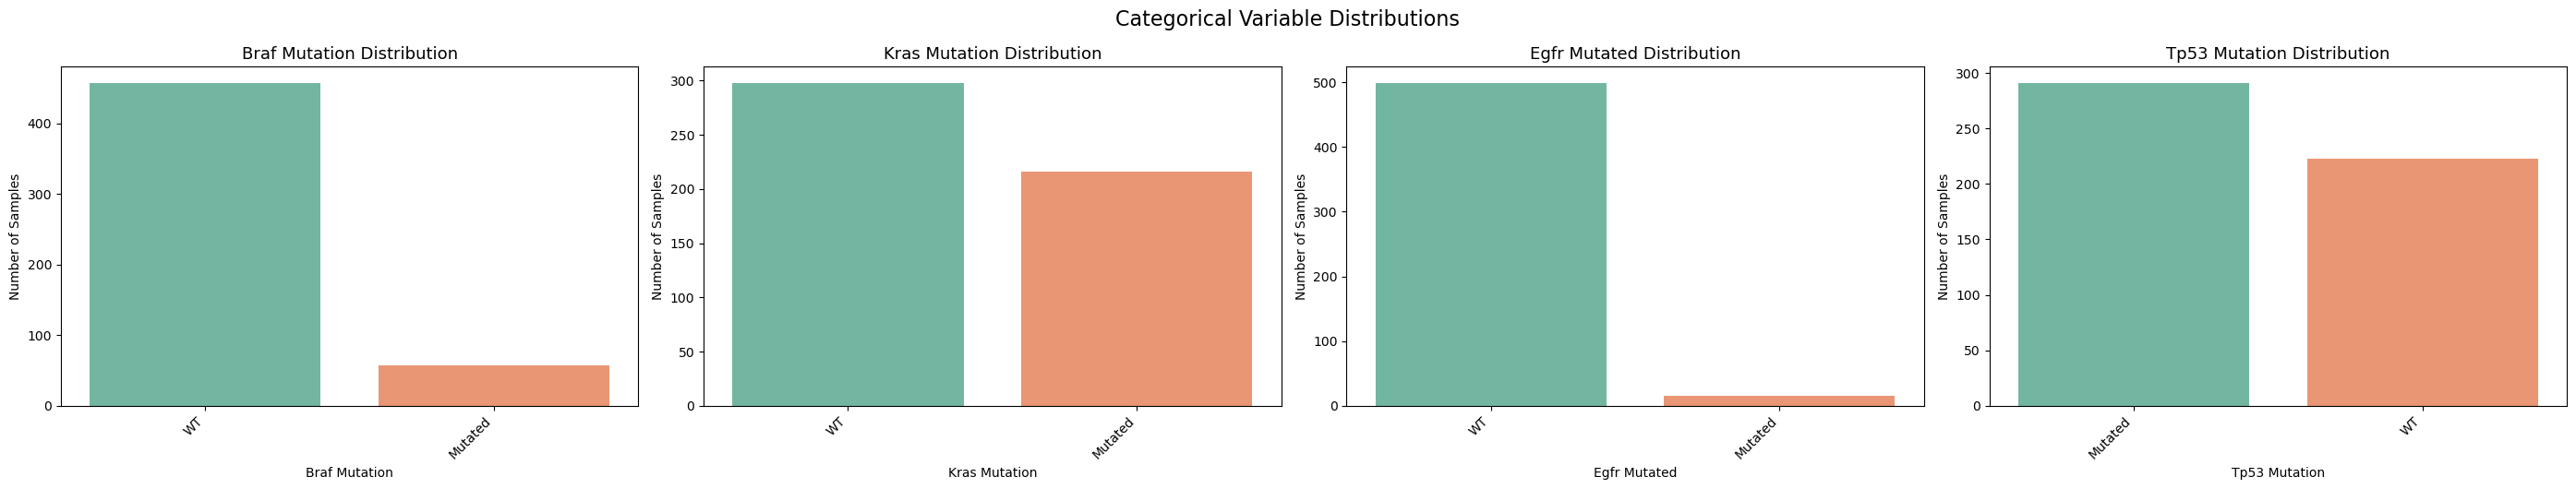

In [117]:
# Mutation columns to explore
mutation_cols = ['braf_mutation', 'kras_mutation', 'egfr_mutated', 'tp53_mutation']
plot_categorical_distributions(cancer_df, mutation_cols)


## 🧬 Tumor Characteristic Distributions (Non-Missing)

The figure shows the distributions of key tumor characteristics among colorectal cancer samples labeled as **Primary cancer**, excluding missing values:

- **Stage**: The majority of samples are in **stage III** and **stage II**, with fewer cases in stages IV and I.
- **Grade**: The distribution is limited and skewed due to significant missing data (see note below).
- **Histological Type**: Most samples fall under the categories **"Neoplasm"** and **"Adenomas and adenocarcinomas"**.
- **Histological Subtype**: Dominated by **"Adenocarcinoma"** and **"Malignant tumor"**, followed by a long tail of less frequent subtypes.



### 📌 Data Quality and Missingness

- **Grade** has **96% missing values** and contributes minimal usable information.  
  👉 **Action**: This variable will be **dropped** from further analysis.

- **Stage** has **~57% missing values**, which is considerable.  
  👉 **Action**:  Using only complete cases for exploratory plots.

- **Histological Type** and **Histological Subtype** have **no missing data** and are informative.  
  👉 **Action**: These variables will be **retained** and may be considered for stratification or inclusion in predictive models. Very low classes in count will be merged, this can be done based on domain knowledge, I will do it based on count only for simplicity





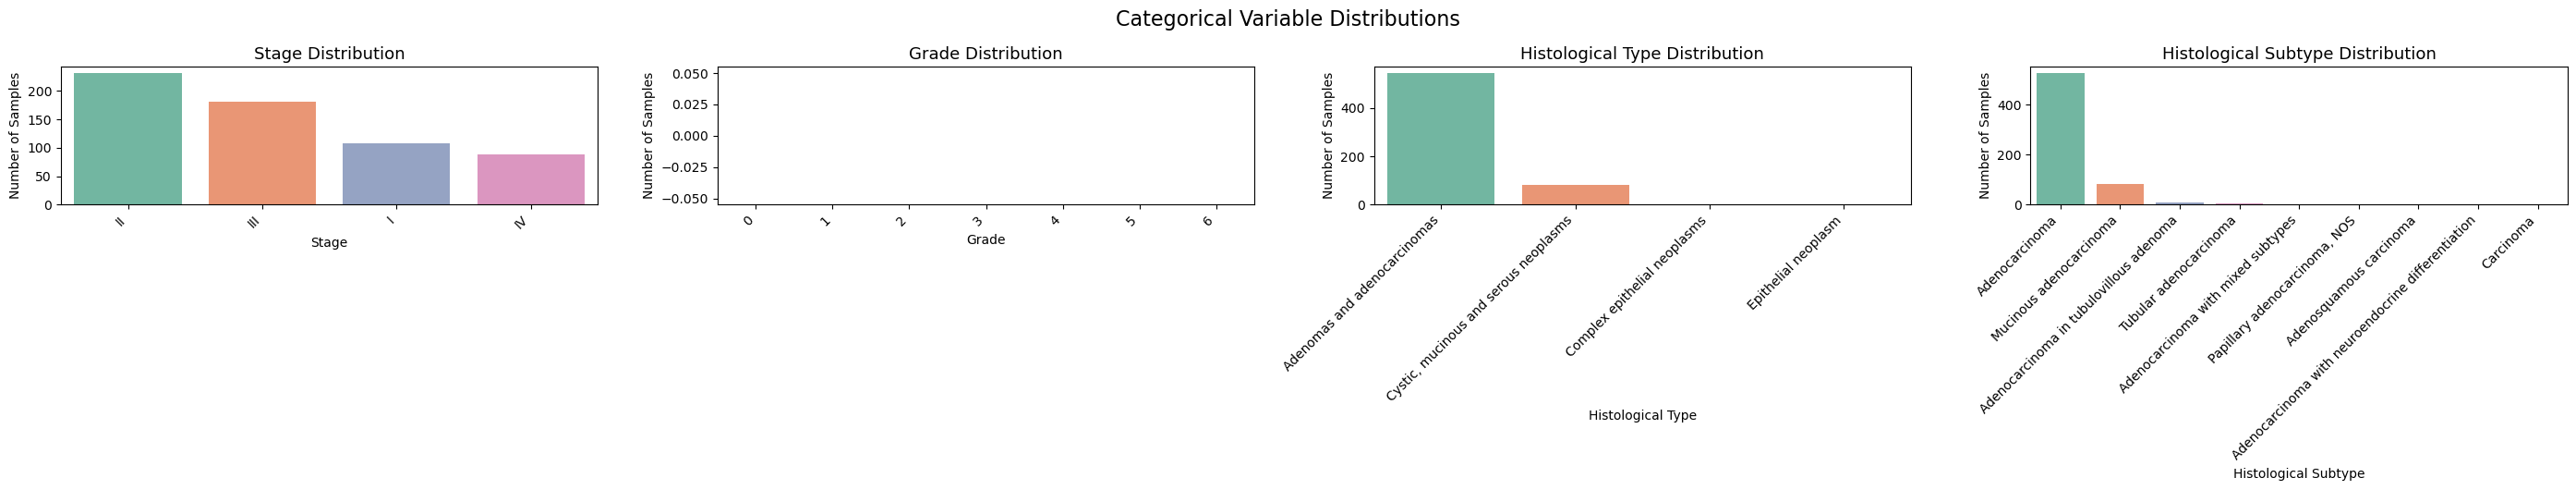

In [118]:
# Tumor characteristic columns to explore
tumor_cols = ['stage', 'grade',  'histological_type', 'histological_subtype']
plot_categorical_distributions(cancer_df, tumor_cols)


In [119]:
# Merge rare subtypes into 'Other'
subtype_counts = cancer_df['histological_subtype'].value_counts()
rare_subtypes = subtype_counts[subtype_counts < 10].index

cancer_df['histological_subtype'] = cancer_df['histological_subtype'].replace(rare_subtypes, 'Other')


# Merge rare types into 'Other'
subtype_counts = metadata_df['histological_type'].value_counts()
rare_subtypes = subtype_counts[subtype_counts < 10].index

cancer_df['histological_type'] = cancer_df['histological_type'].replace(rare_subtypes, 'Other')


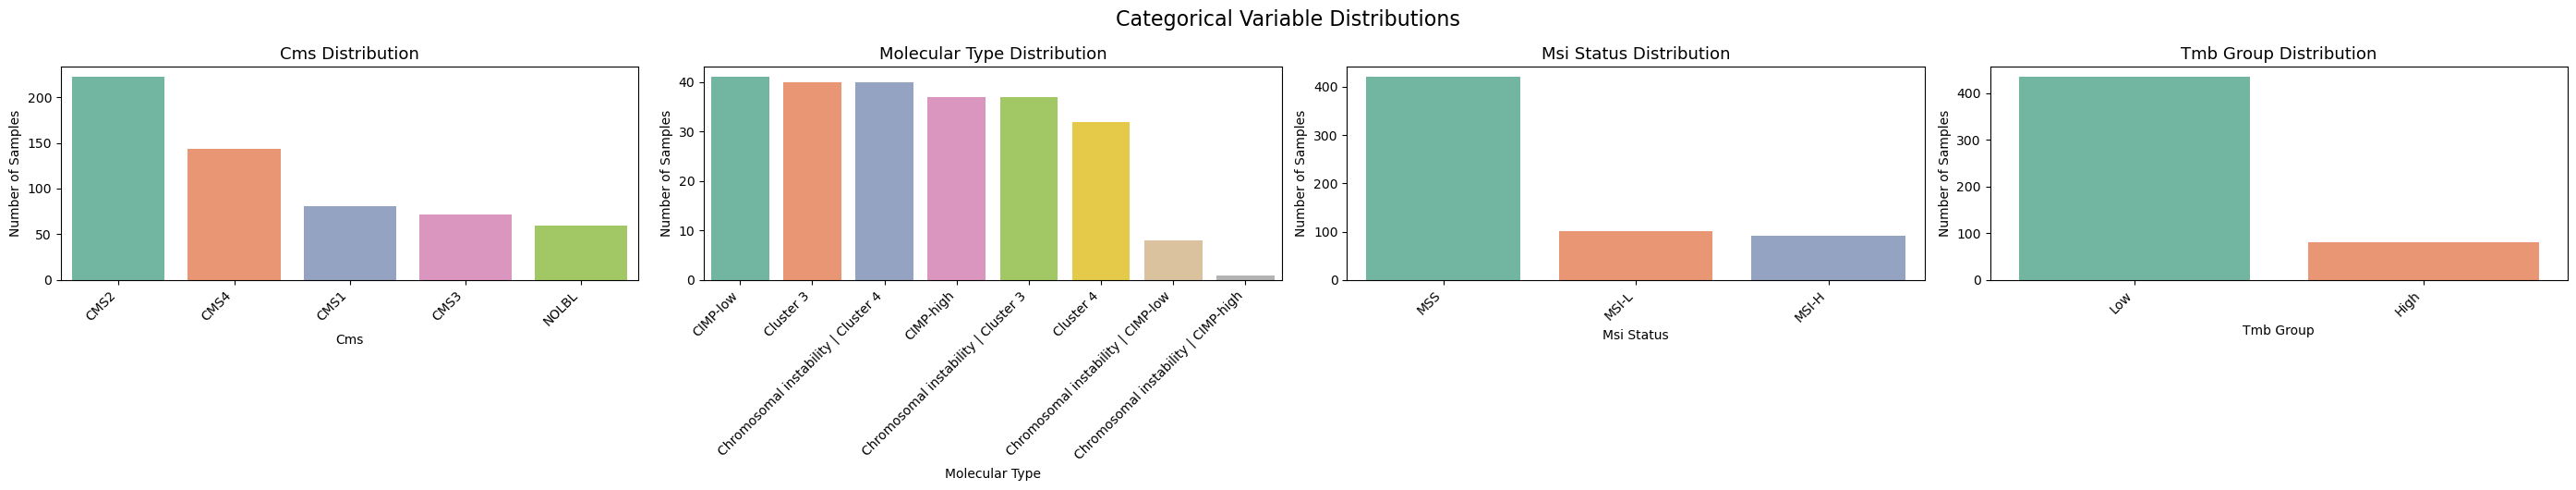

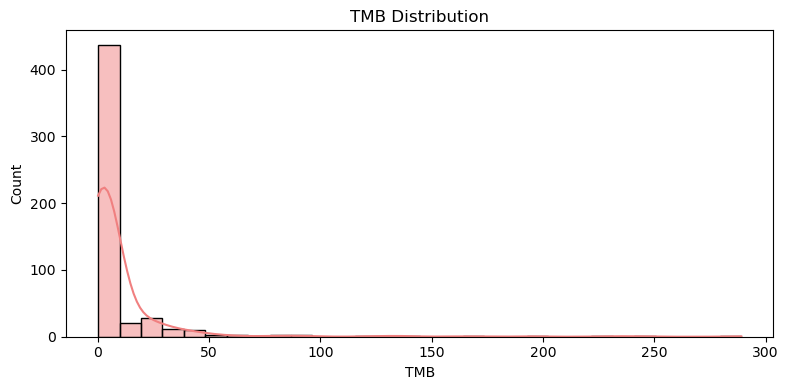

In [120]:
# Molecular classification columns
molecular_categorical = ['cms', 'molecular_type', 'msi_status', 'tmb_group']
molecular_continuous = ['tmb']
plot_categorical_distributions(cancer_df, molecular_categorical)
plot_continuous_distributions(cancer_df, molecular_continuous)


In [121]:
cancer_df['molecular_type'].unique()

array([nan, 'CIMP-high', 'Cluster 4',
       'Chromosomal instability | Cluster 3', 'Cluster 3',
       'Chromosomal instability | CIMP-low',
       'Chromosomal instability | Cluster 4', 'CIMP-low',
       'Chromosomal instability | CIMP-high'], dtype=object)

In [122]:

# Function to split based on known categories
# Function to extract each category type
def extract_types(val):
    if pd.isna(val):
        return pd.Series([np.nan, np.nan, np.nan])
    
    cluster = np.nan
    cimp = np.nan
    instability = np.nan
    
    if "Cluster" in val:
        cluster = [x for x in val.split(" | ") if "Cluster" in x][0]
    if "CIMP" in val:
        cimp = [x for x in val.split(" | ") if "CIMP" in x][0]
    if "Chromosomal instability" in val:
        instability = 1
    else:
        instability = 0
    
    
    return pd.Series([cluster, cimp, instability])

# Apply function to create new columns

cancer_df[['cluster', 'cimp', 'instability']] =cancer_df['molecular_type'].apply(extract_types)
cancer_df= cancer_df.drop(columns='molecular_type')

In [123]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, TCGA-3L-AA1B-01A-11R-A37K-07 to TCGA-G5-6641-01A-11R-A32Z-07
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   628 non-null    float64
 1   biopsy_subsite        462 non-null    object 
 2   braf_mutation         514 non-null    object 
 3   biopsy_site           628 non-null    object 
 4   cms                   578 non-null    object 
 5   distal_vs_proximal    617 non-null    object 
 6   egfr_mutated          514 non-null    object 
 7   grade                 0 non-null      object 
 8   histological_subtype  628 non-null    object 
 9   histological_type     628 non-null    object 
 10  kras_mutation         514 non-null    object 
 11  msi_status            613 non-null    object 
 12  os_status             628 non-null    object 
 13  os_time               628 non-null    float64
 14  primary_site          628 n

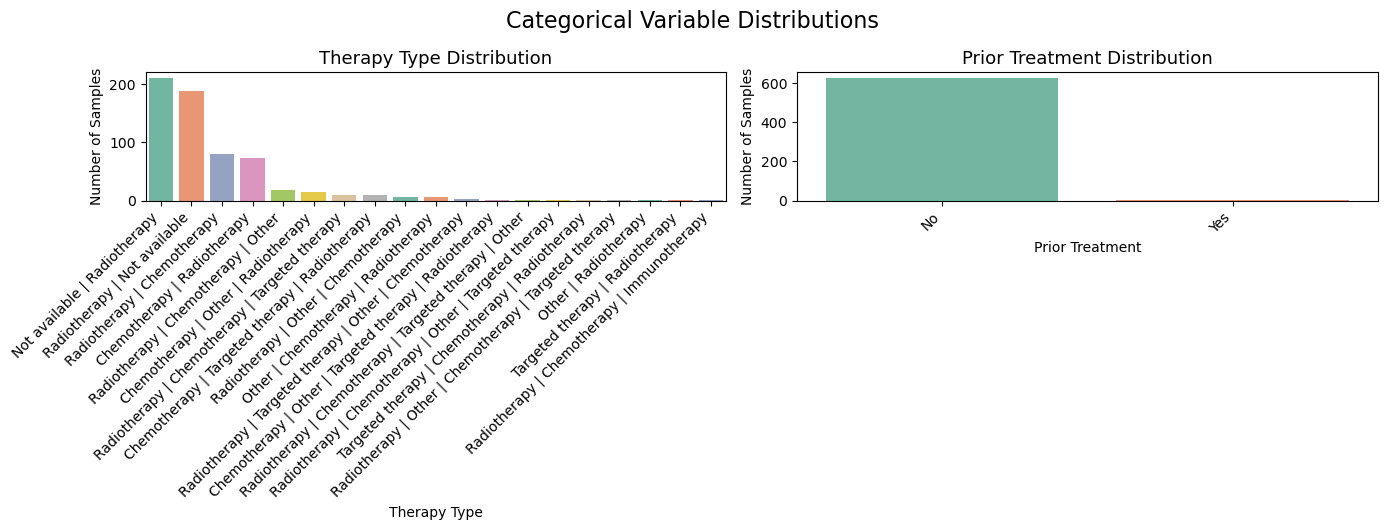

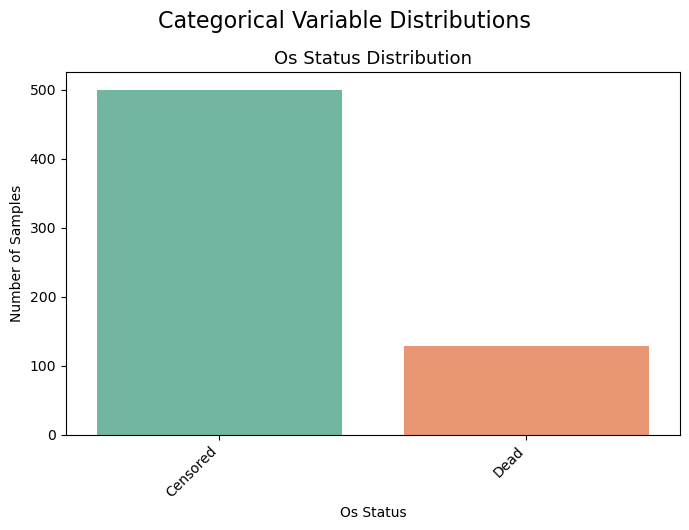

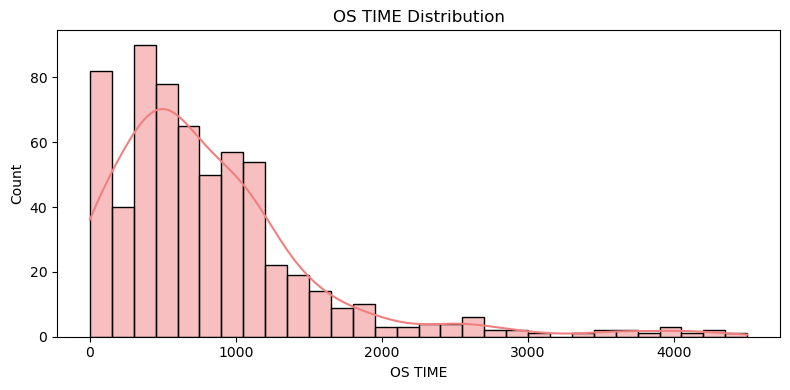

In [124]:
# Define our new column groups
treatment_categorical = ['therapy_type', 'prior_treatment']
survival_continuous = ['os_time']
survival_categorical = ['os_status']  
plot_categorical_distributions(cancer_df, treatment_categorical)
plot_categorical_distributions(cancer_df, survival_categorical)
plot_continuous_distributions(cancer_df, survival_continuous)



In [125]:
def extract_first_line(s):
    if '|' not in s:
        return s
    return s.split('|')[0].strip()

def extract_second_line(s):
    if '|' not in s:
        return 'No second line'
    parts = s.split('|')
    if len(parts) > 1:
        return parts[1].strip()

def has_more_than_two_steps(s):
    if '|' not in s:
        return 0
    return int(s.count('|') > 1)

# Apply the new functions
cancer_df['first_line_treatment'] = cancer_df['therapy_type'].apply(extract_first_line)
cancer_df['second_line_treatment'] = cancer_df['therapy_type'].apply(extract_second_line)
cancer_df['has_further_steps'] = cancer_df['therapy_type'].apply(has_more_than_two_steps)
cancer_df['os_time'] = cancer_df['os_time']


# Drop the original 'therapy_type' column if needed
cancer_df = cancer_df.drop(columns=['therapy_type', 'tmb', 'prior_treatment', 'grade'])

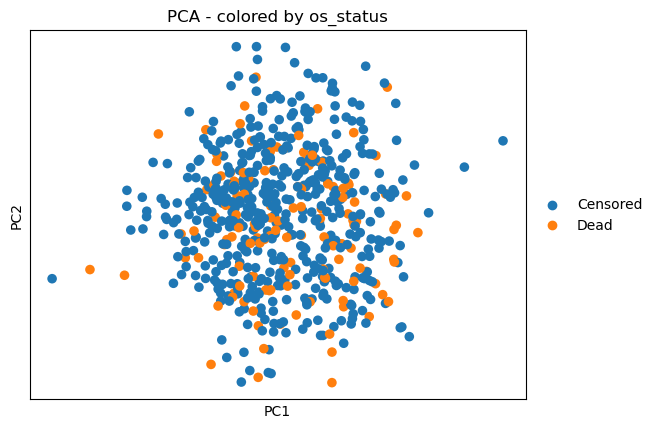

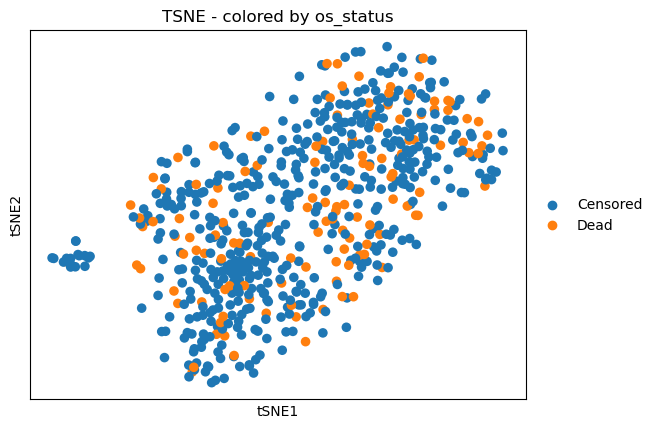

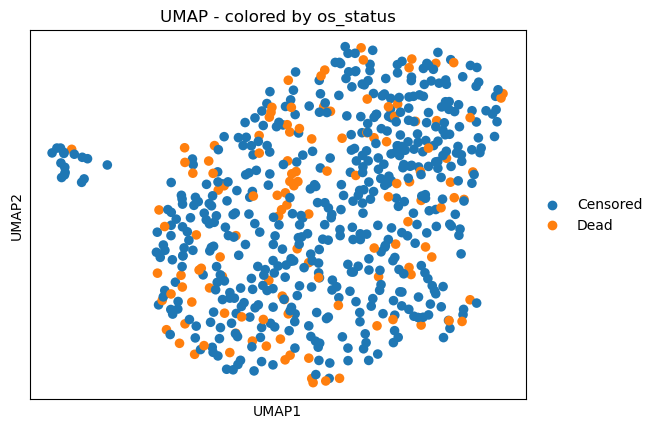

In [126]:
# TMM normalization
expression_df = expression_df.transpose()
expression_tmm = conorm.tmm(expression_df)
# Log scaling
log_tmm = np.log2(expression_tmm + 1)

# Keep genes expressed in at least 10% of the samples
min_samples = log_tmm.shape[1]//5
filtered_expr = log_tmm.loc[(log_tmm > 1).sum(axis=1) > min_samples,:].transpose()
cancer_adata = anndata.AnnData(filtered_expr.loc[filtered_expr.index.intersection(cancer_df.index)])


# Add all columns from metadata_df to adata.obs
for col in cancer_df.columns:
    cancer_adata.obs[col] = cancer_df[col]

# # Select Highly Variable Genes 
sc.pp.highly_variable_genes(cancer_adata, flavor='seurat', n_top_genes=300)
cancer_adata = cancer_adata[:, cancer_adata.var['highly_variable']]

# Scale data (z-score genes)
sc.pp.scale(cancer_adata)

# PCA
sc.tl.pca(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

#plotting by biopsy site
plot_reductions(cancer_adata, 'os_status')

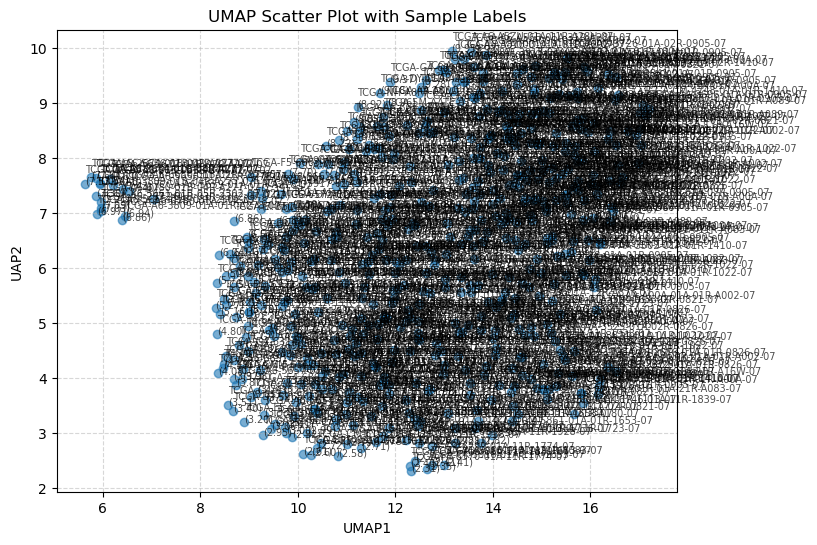

In [127]:
# Extract UMAP coordinates
umap1 = cancer_adata.obsm['X_umap'][:, 0]
umap2 = cancer_adata.obsm['X_umap'][:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(umap1, umap2, alpha=0.6)

# Correct axis labels
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP Scatter Plot")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [128]:
# Extract PC2 scores 
umap1_scores = cancer_adata.obsm['X_umap'][:, 0]

# Define outlier threshold (example: abs(umap) > 5)
threshold = 8
mask = np.abs(umap1_scores) > threshold

# Filter AnnData to keep only samples within threshold
cancer_adata = cancer_adata[mask, :].copy()

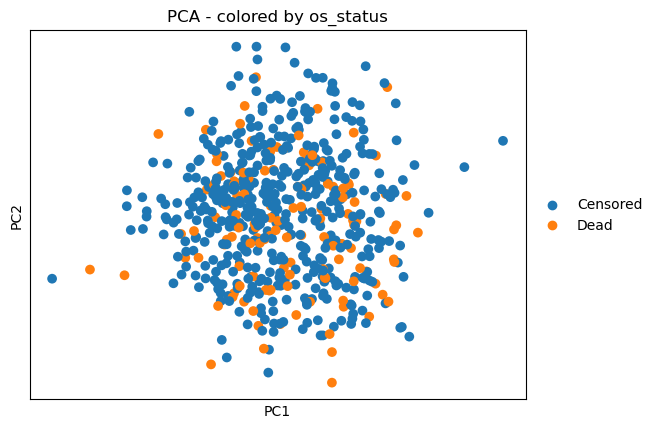

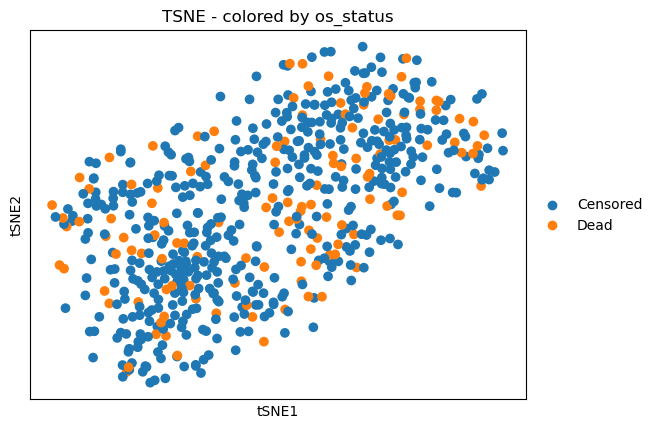

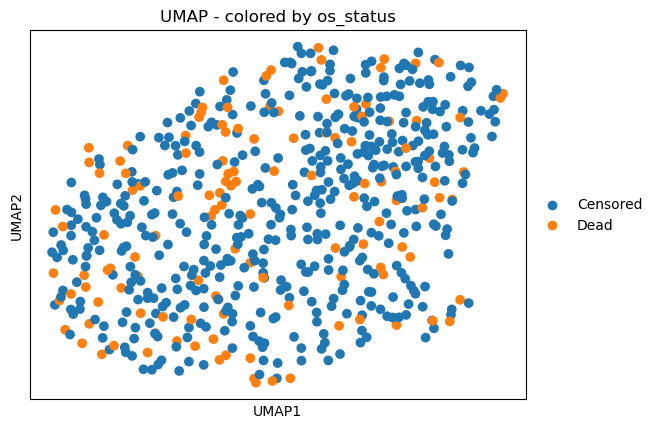

In [129]:
plot_reductions(cancer_adata, 'os_status')

In [130]:
expression_df = expression_df.transpose()
run_pipeline(expression_df, cancer_df, scaled_filtered,
                 ['os_status','age','gender'],('os_status','Censored','Dead'), '../results/cancer_gsea', '../data/hallmarks.gmt')

🔹 Running DESeq2...


Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.77 seconds.

Fitting dispersions...
... done in 17.55 seconds.

Fitting dispersion trend curve...
... done in 0.87 seconds.

Fitting MAP dispersions...
... done in 16.80 seconds.

Fitting LFCs...
... done in 11.92 seconds.

Calculating cook's distance...
... done in 1.15 seconds.

Replacing 729 outlier genes.

Fitting dispersions...
... done in 1.17 seconds.

Fitting MAP dispersions...
... done in 0.59 seconds.

Fitting LFCs...
... done in 1.70 seconds.

Running Wald tests...
... done in 3.14 seconds.



Log2 fold change & Wald test p-value: os_status Censored vs Dead
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG          1.432690        0.006625  0.170333  0.038892  0.968977  0.989141
A1BG-AS1      8.166456        0.007965  0.114369  0.069645  0.944476  0.979108
A1CF        727.615422        0.009528  0.112564  0.084642  0.932546  0.973704
A2M       12007.725625       -0.085503  0.100264 -0.852778  0.393782  0.667665
A2M-AS1      15.716948        0.072797  0.113005  0.644199  0.519446  0.759664
...                ...             ...       ...       ...       ...       ...
ZYG11A        3.817841       -0.060788  0.191897 -0.316774  0.751415  0.891261
ZYG11B      893.419252        0.141880  0.062989  2.252439  0.024295  0.155060
ZYX        7264.735954       -0.044536  0.072489 -0.614379  0.538965  0.771136
ZZEF1      2117.190609        0.119002  0.063665  1.869198  0.061595  0.261382
ZZZ3       1225.635647        0.113661  0.051018  2.227867  0.0258

In [131]:
pre_res= pd.read_csv('../results/cancer_gsea/gsea_results/gsea_summary.csv')
significant_sets = pre_res[pre_res['FDR q-val'] < 0.25]
# Flatten all genes split by ';' into a list
all_genes = [g for gene_str in significant_sets['Lead_genes'] for g in gene_str.split(';')]

# Get unique genes
unique_genes = list(set(all_genes))

# Filter expression DataFrame columns by these genes
scaled_df_filtered = scaled_filtered.loc[:, scaled_filtered.columns.isin(unique_genes)]

scaled_df_filtered.shape

(628, 2535)

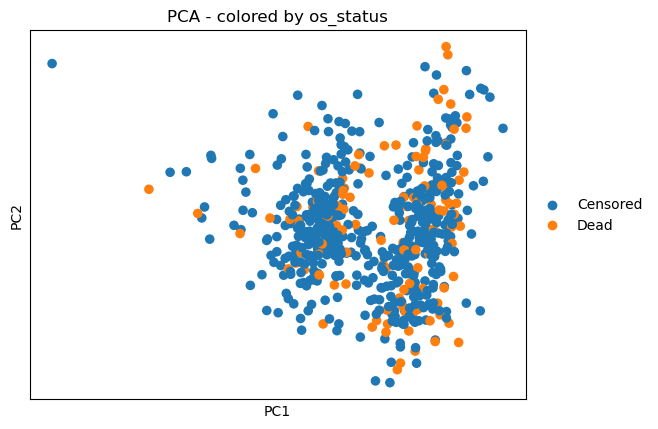

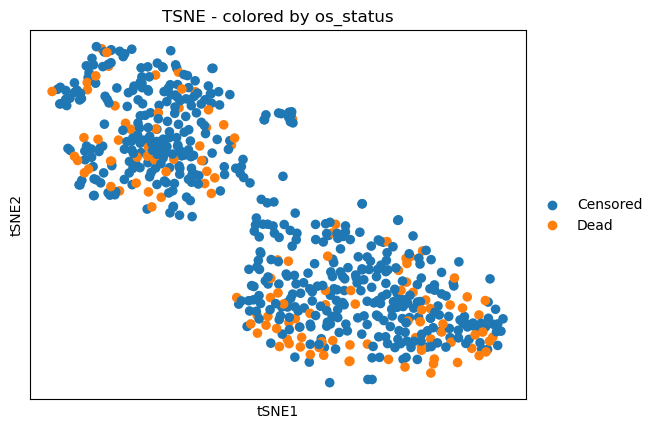

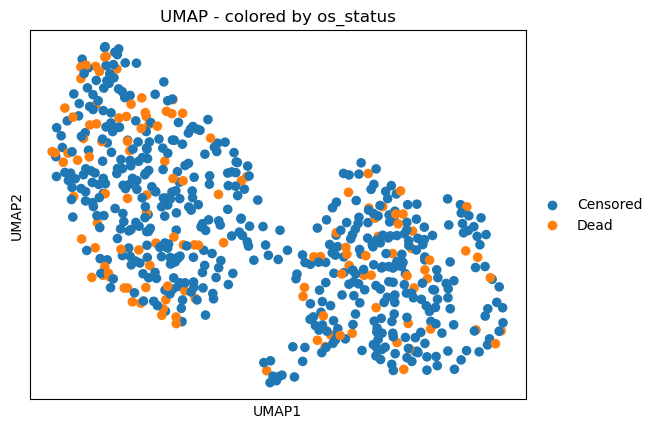

In [132]:
cancer_adata = anndata.AnnData(scaled_df_filtered)


# Add all columns from metadata_df to adata.obs
for col in cancer_df.columns:
    cancer_adata.obs[col] = cancer_df[col]


# Scale data (z-score genes)
sc.pp.scale(cancer_adata)

# PCA
sc.tl.pca(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

# t-SNE
sc.tl.tsne(cancer_adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(cancer_adata, use_rep='X_pca')
sc.tl.umap(cancer_adata)

#plotting by biopsy site
mplt.plot_reductions(cancer_adata, 'os_status')

leiden
0    347
1    281
Name: count, dtype: int64


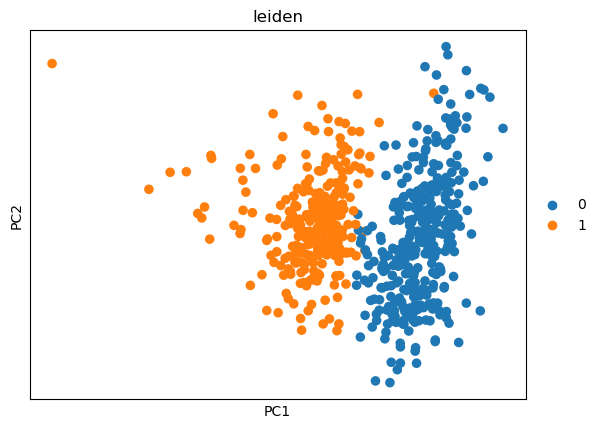

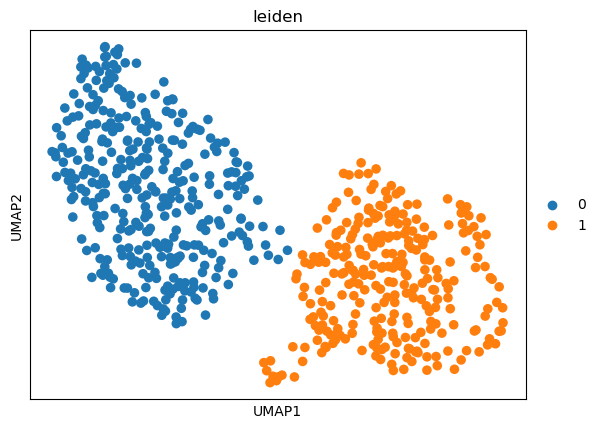

In [133]:
sc.pp.neighbors(cancer_adata, use_rep='X_umap') 
sc.tl.leiden(cancer_adata, resolution=0.05)     

# Add Leiden clusters to metadata
print(cancer_adata.obs['leiden'].value_counts())
# Plot PCA with Leiden clusters
sc.pl.pca(cancer_adata, color=['leiden'])
# Plot UMAP with Leiden clusters
sc.pl.umap(cancer_adata, color=['leiden'])

In [134]:
from sklearn.metrics import adjusted_rand_score

if 'leiden' in cancer_adata.obs.columns:
    ref = cancer_adata.obs['leiden'].astype(str).values
    scores = {}
    for col in cancer_adata.obs.columns:
        vals = cancer_adata.obs[col].astype(str).values
        try:
            scores[col] = adjusted_rand_score(ref, vals)
        except Exception:
            scores[col] = np.nan
    # rank columns by similarity to 'leiden'
    print(sorted(scores.items(), key=lambda x: - (x[1] if x[1] is not None else -1))[:10])
print(scores)

[('leiden', 1.0), ('instability', 0.5234049948218052), ('cluster', 0.2596341360642402), ('cimp', 0.09833852261340205), ('cms', 0.006157957789225821), ('second_line_treatment', 0.004052723617026211), ('histological_type', 0.003355659367527945), ('os_time', 0.0022295706522643148), ('biopsy_subsite', 0.0020679120514633114), ('tp53_mutation', 0.0017245115881988943)]
{'age': -0.0004381955816591095, 'biopsy_subsite': 0.0020679120514633114, 'braf_mutation': -0.0028237538452208664, 'biopsy_site': -0.0013479379271965747, 'cms': 0.006157957789225821, 'distal_vs_proximal': 0.00010489940888228082, 'egfr_mutated': 0.00027148131835709775, 'histological_subtype': -0.00404470644534816, 'histological_type': 0.003355659367527945, 'kras_mutation': -0.0027951661891979537, 'msi_status': -0.001550079237544497, 'os_status': -0.0046687144723043025, 'os_time': 0.0022295706522643148, 'primary_site': -0.0013479379271965747, 'gender': 9.045512433828952e-05, 'stage': -0.0003958862260648446, 'tmb_group': -0.0023630

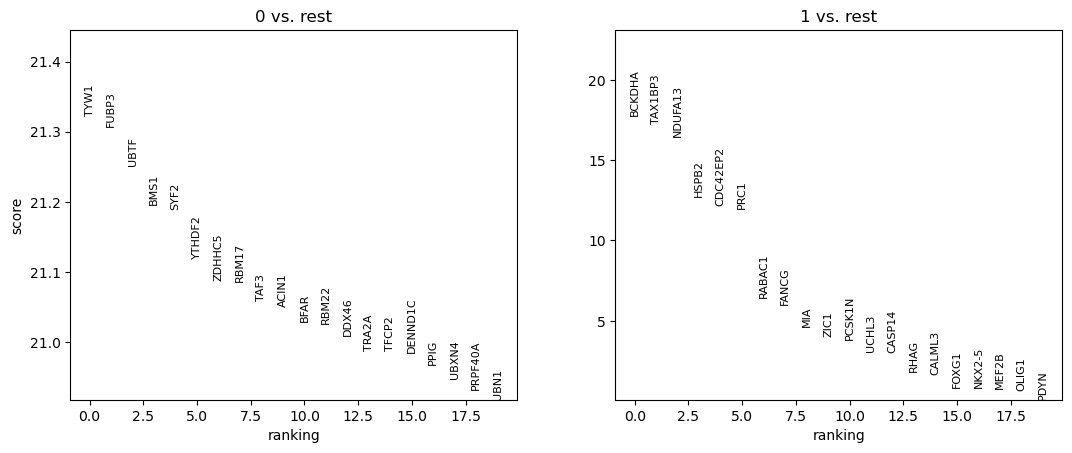

In [135]:
sc.tl.rank_genes_groups(cancer_adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(cancer_adata, n_genes=20, sharey=False)

In [136]:
import gseapy as gp
import pandas as pd

# Example: get top 50 genes for cluster 0 and 1 from your Scanpy results
# (rank_genes_groups stores them in adata.uns)
marker_genes = pd.DataFrame({
    group: cancer_adata.uns['rank_genes_groups']['names'][group]
    for group in cancer_adata.uns['rank_genes_groups']['names'].dtype.names
})

cluster0_genes = marker_genes['0'][:50].tolist()
cluster1_genes = marker_genes['1'][:50].tolist()

# GO Biological Process enrichment for cluster 0
enrich0 = gp.enrichr(
    gene_list=cluster0_genes,
    gene_sets=['GO_Biological_Process_2021'], 
    organism='Human',  
    outdir=None  
)

# GO Biological Process enrichment for cluster 1
enrich1 = gp.enrichr(
    gene_list=cluster1_genes,
    gene_sets=['GO_Biological_Process_2021'],
    organism='Human',
    outdir=None
)

# View top results
print("Cluster 0 top GO terms:")
print(enrich0.results.head(10))

print("\nCluster 1 top GO terms:")
print(enrich1.results.head(10))


Cluster 0 top GO terms:
                     Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   
5  GO_Biological_Process_2021   
6  GO_Biological_Process_2021   
7  GO_Biological_Process_2021   
8  GO_Biological_Process_2021   
9  GO_Biological_Process_2021   

                                                Term  Overlap       P-value  \
0        mRNA splicing, via spliceosome (GO:0000398)    9/274  2.285898e-08   
1  RNA splicing, via transesterification reaction...    8/251  1.874508e-07   
2                       mRNA processing (GO:0006397)    8/300  7.253428e-07   
3  positive regulation of transcription, DNA-temp...  11/1183  1.306818e-04   
4  positive regulation of pattern recognition rec...     2/15  6.299021e-04   
5         regulation of rRNA processing (GO:2000232)     2/16  7.187392e-04   
6  regulation of transcription by RNA polymerase ...     2/

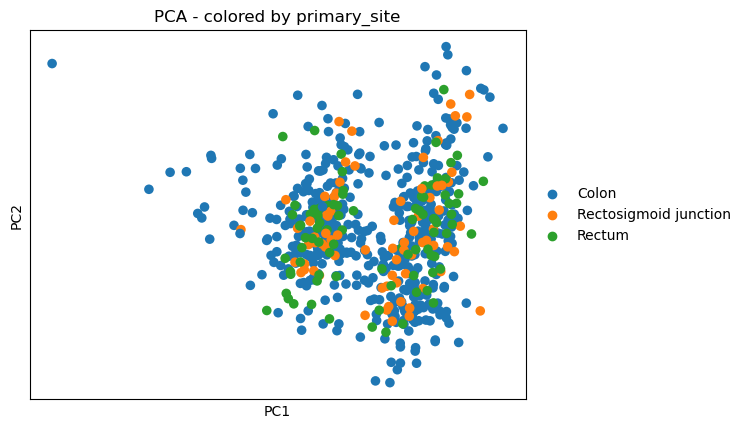

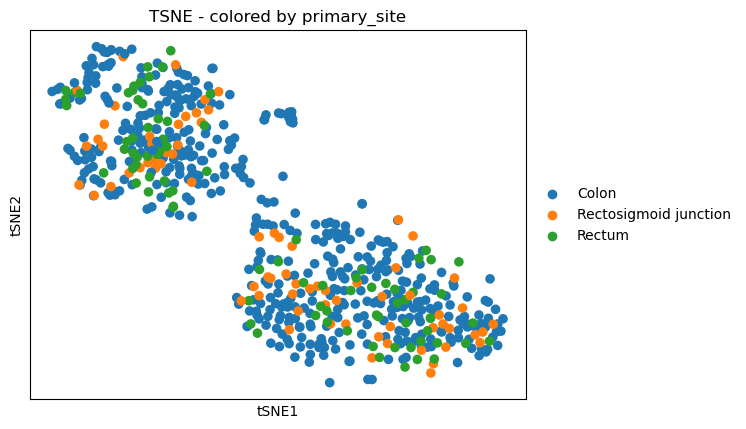

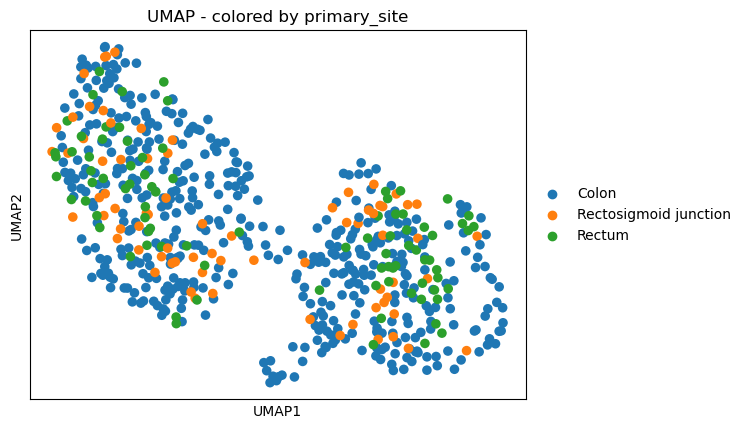

In [137]:
mplt.plot_reductions(cancer_adata, 'primary_site',save_dir='../data/cancer_survival')

In [138]:
# Loadings: genes x PCs
loadings = cancer_adata.varm['PCs']

# PC1 contributions
pc1_loadings = loadings[:, 0]  # 0-based index for PC1

# Sort genes by absolute contribution
gene_names = cancer_adata.var_names
top_genes_pc1 = pd.Series(pc1_loadings, index=gene_names).abs().sort_values(ascending=False).head(10)

print(top_genes_pc1)

FUBP3      0.029027
LAMC1      0.028966
TAF3       0.028916
FCHSD2     0.028871
PARVA      0.028848
PIP4K2B    0.028642
SIK3       0.028618
LIMS1      0.028593
PIP4K2A    0.028449
UBE2H      0.028426
dtype: float64


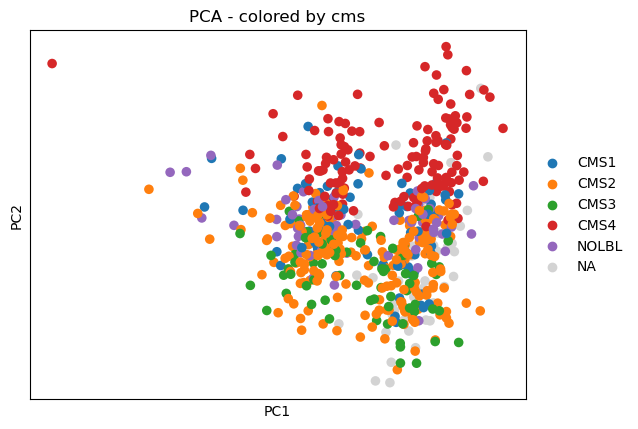

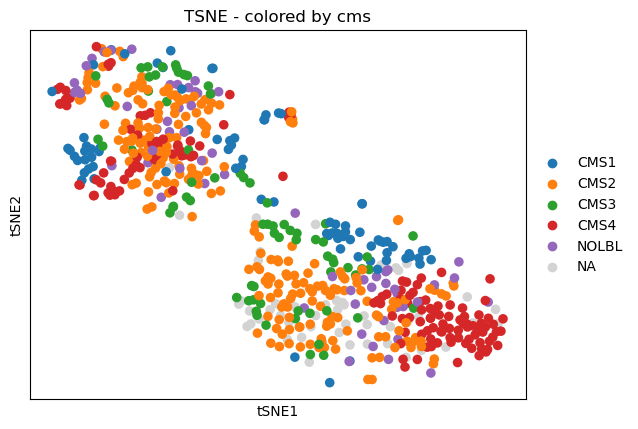

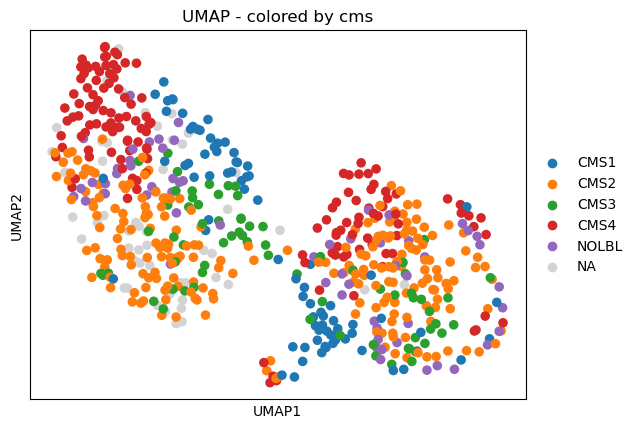

In [139]:
#plotting by biopsy site
mplt.plot_reductions(cancer_adata, 'cms')

In [140]:
cancer_df= cancer_df.drop(columns=['cluster', 'cimp', 'instability'])

In [ ]:
filtered_expr = filtered_expr.loc[cancer_df.index]
pre_res= pd.read_csv('../results/cancer_gsea/gsea_results/gsea_summary.csv')
significant_sets = pre_res[pre_res['FDR q-val'] < 0.25]
# Flatten all genes split by ';' into a list
all_genes = [g for gene_str in significant_sets['Lead_genes'] for g in gene_str.split(';')]

# Get unique genes
unique_genes = list(set(all_genes))

# Filter expression DataFrame columns by these genes
filtered_expr =  filtered_expr.loc[:, filtered_expr.columns.isin(unique_genes)]


In [ ]:
# save cancer metadats
cancer_df.to_csv('../data/cancer_metadata.csv')
# Save as CSV
filtered_expr.to_csv('../data/cancer_tmm_log.csv')
